# 第四题：实现K-means

实验内容：
1. 实现一个K-means聚类算法
2. 计算外部指标FMI和NMI
3. 对聚类结果可视化
4. 完成第二个数据集上myKmeans与层次聚类(single)算法的对比

我们要实现一个K-means算法，也称为原型聚类算法。

## 初始化

K-means在实现的时候，首先需要选取类簇中心。类簇中心的选取方法有很多，我们这里使用最简单的方法，随机选取。也就是，从给定的待聚类的样本中，随机选取 $K$ 个样本，作为 $K$ 个类簇的中心。

## 优化

选取类中心后，就需要不断的调成类中心的位置，开始优化过程，优化主要分为两步：

### 第一步

计算所有样本到 $K$ 个类中心的距离。每个样本，选择距自己最近的类中心作为自己属于的类簇。（这里的距离我们选择欧式距离）

### 第二步

针对第一步分出来的 $K$ 个类簇，计算每个类簇内样本的均值，将计算得到的 $K$ 个均值向量，作为这 $K$ 个类簇新的中心。

### 然后循环第一步和第二步，直至一定的迭代次数，或类中心无显著的位置改变为止。

# 1. 导入模块

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. 生成数据集

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples = 1500, random_state = 170)

这里的X和y分别代表样本和对应的真实标记。

使用plt.scatter绘制散点图，参数c是一个`np.ndarray`，表示类别，相同的值会有相同的颜色。

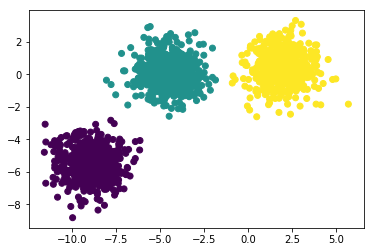

In [3]:
plt.scatter(X[:, 0], X[:, 1], c = y)

# 3. 欧式距离的实现

给定向量 $x \in \mathbb{R}^m$，$y \in \mathbb{R}^m$，两个向量的欧式距离定义为：

$$
E(x, y) = \sqrt{\sum^m_{i = 1} (x_i - y_i)^2}
$$

其中, $i$ 表示向量的第 $i$ 个分量。

我们要实现一个可以计算多个样本组成的矩阵 $X$，与某一个类中心 $y$ 之间欧氏距离的函数。

给定输入矩阵 $X \in \mathbb{R}^{n \times m}$，其中 $n$ 是样本数，$m$ 是特征数，给定输入的类簇中心 $y \in \mathbb{R}^m$。

我们要计算 $n$ 个样本到某一类簇中心 $y$ 的欧式距离，最后的结果是 $E \in \mathbb{R}^{n}$，每个元素表示矩阵 $X$ 中的每个样本到类中心 $y$ 的欧式距离。

In [4]:
def compute_distance(X, y):
    '''
    计算样本矩阵X与类中心y之间的欧氏距离
    
    Parameters
    ----------
    X, np.ndarray, 样本矩阵 X, 维度：(n, m)
    
    y, np.ndarray, 类中心 y，维度：(m, )
    
    Returns
    ----------
    distance, np.ndarray, 样本矩阵 X 每个样本到类中心 y 之间的欧式距离，维度：(n, )
    '''
    distance = np.ndarray(X.shape[0])
    
    for i in range(X.shape[0]):
        distance[i] = (X[i,:].T-y).dot((X[i,:].T-y).T)

    distance = np.sqrt(distance)
    return distance

In [5]:
# 测试样例
print(compute_distance(np.array([[0, 0], [0, 1]]), np.array([0, 1]))) # [ 1.  0.]
print(compute_distance(np.array([[0, 0], [0, 1]]), np.array([1, 1]))) # [ 1.41421356  1.        ]

[ 1.  0.]
[ 1.41421356  1.        ]


下面开始实现K-means聚类算法

In [46]:
class myKmeans:
    def __init__(self, n_clusters, max_iter = 100):
        '''
        初始化，三个成员变量
        
        Parameters
        ----------
        n_clusters: int, 类簇的个数
        
        max_iter, int, default 100, 最大迭代轮数，默认为100
        
        '''
        # 表示类簇的个数
        self.n_clusters = n_clusters
        
        # 表示最大迭代次数
        self.max_iter = int(max_iter)
        
        # 类簇中心
        self.centroids = None
    
    def choose_centroid(self, X):
        '''
        选取类簇中心
        
        Parameters
        ----------
        X: np.ndarray, 样本矩阵X，维度：(n, m)
        
        Returns
        ----------
        centroids: np.ndarray, 维度：(n_clusters, m)
        
        '''
        centroids = X[np.random.choice(np.arange(len(X)), self.n_clusters, replace = False), :]
        return centroids
    
    def compute_label(self, X):
        '''
        给定样本矩阵X，结合类中心矩阵self.centroids，计算样本矩阵X内每个样本属于哪个类簇
        
        Parameters
        ----------
        X: np.ndarray, 样本矩阵X，维度：(n, m)
        
        Returns
        ----------
        labels: np.ndarray, 维度：(n, )
        
        '''
        # 将每个样本到每个类簇中心的距离存储在distances中，每行表示当前样本对于不同的类中心的距离
        distances = np.empty((len(X), self.n_clusters))
        
        # 遍历类中心，对每个类中心，计算所有的样本到这个类中心的距离
        for index in range(len(self.centroids)):
            
            # 计算样本矩阵X所有样本到当前类中心的距离，存储在distances中的第index列中
            # YOUR CODE HERE
            distances[:, index] = compute_distance(X, self.centroids[index])
            
        # 取distances每行最小值的下标，这个下标就是这个样本属于的类簇的标记
        # YOUR CODE HERE
        labels = np.argmin(distances, axis=1)
        
        # 返回每个样本属于的类簇的标记
        return labels
    
    def fit(self, X):
        '''
        聚类，包含类中心初始化，类中心优化两个部分
        
        Parameters
        ----------
        X: np.ndarray, 样本矩阵X，维度：(n, m)
        
        '''
        # 类中心随机初始化
        self.centroids = self.choose_centroid(X)
        
        # 优化self.max_iter轮
        for epoch in range(self.max_iter):
            # 计算当前所有样本的属于哪个类簇
            labels = self.compute_label(X)
            
            # 重新计算每个类簇的类中心
            for index in range(self.n_clusters):
                # 重新计算第 index 个类中心，对属于这个类簇的样本取均值
                # YOUR CODE HERE
                self.centroids[index, :] = X[labels == index].sum(axis=0) / X[labels == index].shape[0]

# 4. 聚类

In [47]:
# 初始化一个3类簇的模型
model = myKmeans(3)

# 对X进行聚类，计算类中心
model.fit(X)

# 计算X的类标记
prediction = model.compute_label(X)

(3, 2)


# 5. 聚类结果可视化

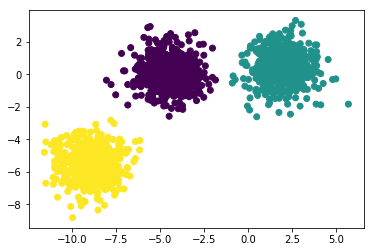

In [48]:
# 使用我们的预测结果上色
plt.scatter(X[:, 0], X[:, 1], c = prediction)

# 6. 评价指标

这里，我们选用两个外部指标，FMI和NMI。

In [49]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score

In [50]:
normalized_mutual_info_score(y, prediction)

1.0

In [51]:
fowlkes_mallows_score(y, prediction)

1.0

可以看到这两个外部指标都为1，说明聚类效果和给出的参考模型一致。

# Test

使用下面提供的数据，完成以下实验：
1. 使用myKmeans和层次聚类算法(AgglomerativeClustering)对该数据进行聚类。
2. 计算出两个模型的FMI和NMI值，并对聚类结果可视化。
3. 分析为什么两个模型的聚类效果会出现如此的不同。

要求：
1. **层次聚类的连接方式选择'single'，即使用两个类簇之间的最小距离**
2. **类簇个数设定为2**

完成下表的填写：

###### 双击此处填写

算法|FMI|NMI
-|-|-
myKmeans|0.499333778964|1.28239907453e-06
AgglomerativeClustering|1.0|1.0

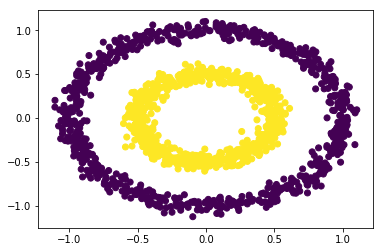

In [52]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples = 1500, factor = .5, noise = .05, random_state = 32)
plt.scatter(X[:, 0], X[:, 1], c = y)

(2, 2)
0.499333778964 1.28239907453e-06


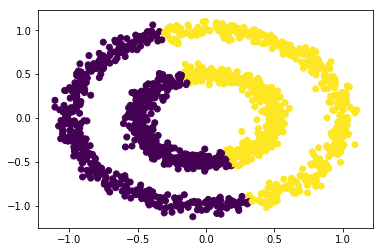

In [53]:
# YOUR CODE HERE
# myKmeans
model = myKmeans(2)

# 对X进行聚类，计算类中心
model.fit(X)

# 计算X的类标记
prediction = model.compute_label(X)
plt.scatter(X[:, 0], X[:, 1], c = prediction)
n = normalized_mutual_info_score(y, prediction)
f = fowlkes_mallows_score(y, prediction)

print(f, n)

1.0 1.0


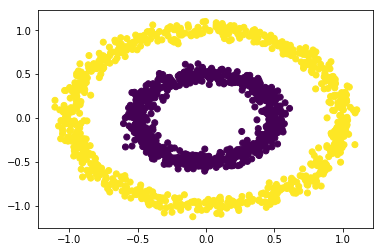

In [57]:
from sklearn.cluster import AgglomerativeClustering

# AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 2, linkage="single")

# 对X进行聚类，计算类中心
model.fit(X)

# 计算X的类标记
prediction = model.labels_
plt.scatter(X[:, 0], X[:, 1], c = prediction)
n = normalized_mutual_info_score(y, prediction)
f = fowlkes_mallows_score(y, prediction)

print(f, n)